In [4]:
# Load Dataset

In [5]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from torchinfo import summary 

class create_tensor_dataset_localization(Dataset):
    def __init__(self, path = './dataset/realData/contact_detection_train.csv', transform = transforms.Compose([transforms.ToTensor()]), num_classes =5,
                 num_features_dataset = 14, num_features_lstm = 2, data_seq = 28, desired_seq = 28, localization= False, collision =False, dof = 7):
        self.path = path
        self.transform = transform
        self.num_features_dataset = num_features_dataset
        self.num_features_lstm = num_features_lstm
        self.data_seq = data_seq
        self.desired_seq = desired_seq
        self.dof = dof
        self.num_classes = num_classes
        self.localization = localization
        self.collision = collision
        if collision and localization:
            print('collision and localization cannot be true at the same time!')
            exit()
            

        self.read_dataset()
        self.data_in_seq()
        
    def __len__(self):
        return len(self.data_target)


    def __getitem__(self, idx: int):

        data_sample = torch.tensor(self.data_input.iloc[idx].values)
        data_sample = torch.reshape(data_sample, (self.dof ,self.num_features_lstm*self.desired_seq))

        target = self.data_target.iloc[idx]

        return data_sample, target


    def read_dataset(self):
        
        # laod data from csv file
        if self.path[(len(self.path)-3): len(self.path)] == 'csv':
            data = pd.read_csv(self.path)
        elif self.path[(len(self.path)-3): len(self.path)] == 'pkl':
            data = pd.read_pickle(self.path)
        # specifying target and data
        data_input = data.iloc[:,1:data.shape[1]]
        data_target = data.iloc[:,0]

        if not self.localization:
            data_target.loc[data_target.iloc[:]!=0] = 1

        if self.localization or self.collision:
            #if 0 in data_target.unique():
            data_input = data_input.loc[data_target.iloc[:]!=0, :]
            data_target = data_target.loc[data_target.iloc[:]!=0]
            data_target = data_target-1


        self.data_input = data_input.reset_index(drop=True)
        self.data_target = data_target.reset_index(drop=True)
        

    def data_in_seq(self):

        dof = self.dof

        # resorting item position
        data = np.array( range(0, self.num_features_dataset * self.data_seq ))
        data = data.reshape(self.data_seq, self.num_features_dataset)

        joint_data_pos = []
        for j in range(dof):
                 
            column_index = np.array(range(self.num_features_lstm))*dof +j
            row_index= range(self.data_seq-self.desired_seq, self.data_seq)
            join_data_matrix = data[:, column_index]
            joint_data_pos.append(join_data_matrix.reshape((len(column_index)*len(row_index))))
        
        joint_data_pos = np.hstack(joint_data_pos)

        # resorting (28,28)---> (4,28)(4,28)(4,28)(4,28)(4,28)(4,28)(4,28)

        self.data_input.columns = range(self.num_features_dataset * self.data_seq)
        self.data_input = self.data_input.loc[:][joint_data_pos]


# LSTM model

In [6]:
import argparse
import os
import time
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torchmetrics import ConfusionMatrix, Accuracy
import matplotlib.pyplot as plt
import torch.nn.functional as F
'''
class ZScoreNormalization(nn.Module):
    def __init__(self):
        super(ZScoreNormalization, self).__init__()

    def forward(self, x):
        mean = torch.mean(x, dim=1, keepdim=True)
        std = torch.std(x, dim=1, keepdim=True)
         return (x - mean) / (std + 1e-6)  # Adding epsilon to avoid division by zero

class MinMaxNormalization(nn.Module):
    def __init__(self):
        super(MinMaxNormalization, self).__init__()

    def forward(self, x):
        min_val = torch.min(x, dim=1, keepdim=True)[0]
        max_val = torch.max(x, dim=1, keepdim=True)[0]
        return (x - min_val) / (max_val - min_val + 1e-6)  # Min-Max normalization with epsilon

'''
def get_output(data_loader, model, device):
    model.eval()
    labels_pred = []
    labels_true = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()
            output = model(X_batch) # Return the prediction for each joint step (batch_size, joint_seq)
            
            probabilities = F.softmax(output, dim=1)

            preds = probabilities.argmax(axis=1)  # shape: [batch_size]

            labels_pred.append(preds.cpu().numpy())
            labels_true.append(y_batch.cpu().numpy())

    # Convert lists to arrays
    labels_pred = np.concatenate(labels_pred, axis=0)
    labels_true = np.concatenate(labels_true, axis=0)

    # Convert numpy arrays back to tensors
    labels_pred = torch.tensor(labels_pred, dtype=torch.int64)  # Ensure long tensor for labels
    labels_true = torch.tensor(labels_true, dtype=torch.int64)  # Ensure long tensor for labels

    return labels_pred, labels_true
    
class ZScoreNormalization(nn.Module):
    def __init__(self):
        super(ZScoreNormalization, self).__init__()

    def forward(self, x):
        # Assuming input x has shape (batch_size, DOF,joint_seq)
        batch_size, DOF,joint_seq  = x.shape

        # Create a placeholder for the normalized output
        normalized_x = torch.zeros_like(x)
        
        # Apply normalization for each DOF independently
        for dof in range(DOF):
            # Normalize along the joint_seq dimension for each DOF
            mean = torch.mean(x[:, dof, :], dim=1, keepdim=True)
            std = torch.std(x[:, dof,:], dim=1, keepdim=True)
            normalized_x[:, dof, :] = (x[:, dof, :] - mean) / (std + 1e-6)  # Add epsilon to avoid division by zero
        
        return normalized_x

class lstmBlock(nn.Module):
    def __init__(self, num_features_lstm=1, hidden_size=32, num_layers=3, time_seq=28, dropout=0.5, bidirectional=False):
        super(lstmBlock, self).__init__()
        self.normalization = ZScoreNormalization()
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=num_features_lstm * time_seq,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0  # Apply dropout only if more than one layer
        )
        # Fully connected layer (to predict contact for each joint step)
        if bidirectional:
            self.fc = nn.Linear(hidden_size*2, 1)  
        else:
            self.fc = nn.Linear(hidden_size, 1) 
        
    def forward(self, input, freeze_last_layer=False):
        # Pass the input through the LSTM layer
        self.lstm.flatten_parameters()
        
        normalized_input = self.normalization(input)
        lstm_out, _ = self.lstm(normalized_input)
        # lstm_out shape: (batch_size, joint_seq, hidden_size)

        # Freeze the last layer if required
        if freeze_last_layer:
            for param in self.fc.parameters():
                param.requires_grad = False
        else:
            for param in self.fc.parameters():
                param.requires_grad = True

        joint_step_outputs = self.fc(lstm_out)  # Shape: (batch_size, joint_seq, 1)
        return joint_step_outputs.squeeze()  # Return the prediction for each joint step (batch_size, joint_seq)

class cnnLSTM(nn.Module):
    def __init__(self, num_features_lstm=1, hidden_size=32, num_layers=3, time_seq=28, dropout=0.5, bidirectional=False):
        super(cnnLSTM, self).__init__()
        self.normalization = ZScoreNormalization()
        
         # Define the 1D CNN layers
        self.cnn1 = nn.Conv1d(in_channels=num_features_lstm * time_seq, out_channels=64, kernel_size=3, padding=1)
        self.cnn2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.cnn3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=128,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0  # Dropout only if num_layers > 1
        )

        lstm_output_size = hidden_size * 2 if bidirectional else hidden_size
        
        self.attention = nn.Linear(lstm_output_size, 1)
        
        # Fully connected layer
        self.fc = nn.Linear(lstm_output_size, 1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        # Attention layer
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        

    def forward(self, input, freeze_last_layer=False):
        # Normalize input (batch_size, sequence_length, input_size)
        self.lstm.flatten_parameters()

        normalized_input = self.normalization(input)

        # Reshape for CNN: (batch_size, in_channels, sequence_length)
        cnn_input = normalized_input.permute(0, 2, 1)
        
        # Apply CNN layers
        cnn_out = self.relu(self.bn1(self.cnn1(cnn_input)))
        cnn_out = self.relu(self.bn2(self.cnn2(cnn_out)))
        cnn_out = self.relu(self.bn3(self.cnn3(cnn_out)))
        
        # Reshape for LSTM: (batch_size, sequence_length, input_size)
        cnn_out = cnn_out.permute(0, 2, 1)
        
        # LSTM layer
        lstm_out, _ = self.lstm(cnn_out)
        
        # Apply dropout
        lstm_out = self.dropout(lstm_out)
        
        # Attention mechanism
        #attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        #lstm_out = lstm_out * attention_weights
        
        # Fully connected layer

        # Freeze the last layer if required
        if freeze_last_layer:
            for param in self.fc.parameters():
                param.requires_grad = False
        else:
            for param in self.fc.parameters():
                param.requires_grad = True

        joint_step_outputs = self.fc(lstm_out)  # (batch_size, joint_dof, 1)
        
        return joint_step_outputs.squeeze()  # Squeeze only the last dimension


# Training
## training functions


In [7]:
from torch.utils.data import random_split, DataLoader
def train_loop(model, dataloader, lr, n_epochs, freeze_last_layer=False): #--> 
    model.train()
    # Use Adam optimizer and CrossEntropyLoss as the loss function
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    # Initialize learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
    loss_seq = []
    lr_seq = []
    # Training loop
    for epoch in range(n_epochs):
        running_loss = []
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).long()  # Move data to device
            optimizer.zero_grad()
            # Generate noise and shift as PyTorch tensors
            y_pred = model(X_batch, freeze_last_layer)
            loss = loss_fn(y_pred, y_batch)
            
            loss.backward()
            optimizer.step()
            running_loss.append(loss.cpu().detach().numpy())
        
        avg_loss = np.mean(running_loss)
        print(f"Epoch: {epoch + 1}/{n_epochs} - learning rate: {optimizer.param_groups[0]['lr']:.5f}, classification loss: {avg_loss:.4f}")
        # Update the scheduler with the average loss
        scheduler.step(avg_loss)
        current_lr = optimizer.param_groups[0]['lr']
        if current_lr < lr_threshold:
            print(f"Learning rate has dropped below the threshold of {lr_threshold}. Stopping training.")
            break
        loss_seq.append(avg_loss)
        lr_seq.append(current_lr)

    return model, loss_seq, lr_seq

def plot_loss(loss_seq, lr_seq):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot loss on the primary y-axis
    ax1.plot(loss_seq, label='Loss', color='blue', marker='o')
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Set y-axis limits for loss to include 0
    ax1.set_ylim(bottom=0, top=max(loss_seq) * 1.05)  # Adjust top limit as needed

    ax1.grid(True)

    # Create a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(lr_seq, label='Learning Rate', color='red', marker='o')
    ax2.set_ylabel('Learning Rate', fontsize=14)
    ax2.tick_params(axis='y', labelcolor='red')

    # Set y-axis limits for learning rate to include 0
    ax2.set_ylim(bottom=0, top=max(lr_seq) * 1.05)  # Adjust top limit as needed

    # Add legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='best')

    # Improve layout
    plt.tight_layout()

    # Show the plot
    plt.show()


def validation(dataloaders, names, model,print_data = False):
    model.eval()
    accuracies = []
    with torch.no_grad():
        confusionMatrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)
        accuracy_metric = Accuracy()
        for i in range(len(dataloaders)):
            y_pred, y_test = get_output(dataloaders[i], model, device)
            accuracy_metric.update(y_pred, y_test)
            accuracy = accuracy_metric.compute()
            if print_data: 
                print("Accuracy on ", names[i], ': ', accuracy)
            accuracies.append(accuracy.item()*100)  # Collect accuracy for plotting
            accuracy_metric.reset()
    return accuracies

# Bar chart plotting function
def plot_accuracies(pre_accuracies, post_accuracies, dataloader_names, model_name):
    labels = dataloader_names
    bar_width = 0.35
    index = range(len(labels))

    # Plotting the barchart
    plt.figure(figsize=(10, 6))
    plt.grid(True)

    bars1 = plt.bar(index, pre_accuracies, bar_width, label='Pre-DomainAdaptation Accuracy', color='blue')
    bars2 = plt.bar([i + bar_width for i in index], post_accuracies, bar_width, label='Post-DomainAdaptation Accuracy', color='green')

    # Set y-axis limits from 0 to 100
    plt.ylim(0, 120)

    # Adding labels, title, and legend
    plt.xlabel('Test Dataset', fontsize=14)
    plt.ylabel('Accuracy (%)', fontsize=14)  # Indicating accuracy as a percentage
    plt.title(f'Accuracy Comparison for {model_name}', fontsize=16)
    plt.xticks([i + bar_width / 2 for i in index], labels)
    plt.legend()

    # Adding accuracy values on top of the bars
    for bar in bars1:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}', ha='center', fontsize=12)

    for bar in bars2:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 1, f'{yval:.2f}', ha='center', fontsize=12)

    # Show the plot
    plt.tight_layout()
    plt.show()


## model initialization

In [8]:
# Path to save trained models
main_path = os.getcwd().replace('AIModels','')
path_name = main_path + 'AIModels/trainedModels/'

# Create directory if it does not exist
if not os.path.exists(path_name):
    os.makedirs(path_name)

# Model configuration
num_features_lstm = 1
num_features_dataset =7
train_all_data = False  # Train a model using all available data

collision = False
localization = True

batch_size = 4096
num_classes = 7

torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    print("Using GPU:", torch.cuda.get_device_name())

# Load data and create training and testing sets


training_data = create_tensor_dataset_localization(
    main_path + '/dataset/localization/5dataset_train.pkl',
    num_features_dataset=num_features_dataset, num_features_lstm=num_features_lstm, num_classes=num_classes,
    collision=collision, localization=localization
)
testing_data = create_tensor_dataset_localization(
    main_path + '/dataset/localization/0dataset_test.pkl',
    num_features_dataset=num_features_dataset, num_features_lstm=num_features_lstm, num_classes=num_classes,
    collision=collision, localization=localization
)

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Build the model
model_lstmBlock = lstmBlock(num_features_lstm=num_features_lstm, num_layers=1, hidden_size=64, dropout=0.2, bidirectional=True)
model_lstmBlock.lstm.flatten_parameters()
model_cnnLSTM = cnnLSTM(num_features_lstm=num_features_lstm, num_layers=1, hidden_size=64, dropout=0.2, bidirectional=True)
model_cnnLSTM.lstm.flatten_parameters()

models = [model_lstmBlock, model_cnnLSTM]
models_names = ['model_lstmBlock',  'model_cnnLSTM',]
for model in models:
    model.double().to(device)
lrs = [0.1, 0.01]
loss_fn = nn.CrossEntropyLoss()


Using GPU: Quadro T2000
Feature batch shape: torch.Size([4096, 7, 28])
Labels batch shape: torch.Size([4096])


## loading test data

In [9]:
testing_data = create_tensor_dataset_localization( main_path + '/dataset/localization/0dataset_test.pkl',
        num_features_dataset=num_features_dataset, num_features_lstm=num_features_lstm, num_classes=num_classes,
        collision=collision, localization=localization)
        
test_source_0 = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

'''testing_data = create_tensor_dataset_localization( main_path + '/dataset/test_dataset_source_robot/dataset_test.pkl',
    num_features_dataset=7, num_features_lstm=1, num_classes=7,
    collision=0, localization=1)
    
test_source_robot = DataLoader(testing_data, batch_size=batch_size, shuffle=True)'''


testing_data = create_tensor_dataset_localization( main_path + 'dataset/test_dataset_target_robot/dataset_test.pkl',
    num_features_dataset=num_features_dataset, num_features_lstm=1, num_classes=num_classes,
    collision=0, localization=1)
    
test_target_franka = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

testing_data = create_tensor_dataset_localization( main_path + 'dataset/test_dataset_target_robot_ur10/dataset_test.pkl',
    num_features_dataset=6, num_features_lstm=1, num_classes=6, dof = 6,
    collision=0, localization=1)
    
test_ur10 = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

testing_data = create_tensor_dataset_localization(  main_path + 'dataset/test_dataset_target_robot_ur5/dataset_test.pkl',
    num_features_dataset=6, num_features_lstm=1, num_classes=6, dof = 6,
    collision=0, localization=1)
    
test_ur5 = DataLoader(testing_data, batch_size=batch_size, shuffle=True)

test_dataloaders=[test_source_0, test_target_franka, test_ur5, test_ur10]
dataloaders_names = ['test_source_robot', 'test_target_franka', 'test_ur5', 'test_ur10']


## training 
10% of the target data

-----------------------------    model_lstmBlock ----------------------------- 
Epoch: 1/30 - learning rate: 0.10000, classification loss: 1.8895
Epoch: 2/30 - learning rate: 0.10000, classification loss: 1.3769
Epoch: 3/30 - learning rate: 0.10000, classification loss: 1.1871
Epoch: 4/30 - learning rate: 0.10000, classification loss: 1.0631
Epoch: 5/30 - learning rate: 0.10000, classification loss: 0.9722
Epoch: 6/30 - learning rate: 0.10000, classification loss: 0.9001
Epoch: 7/30 - learning rate: 0.10000, classification loss: 0.8440
Epoch: 8/30 - learning rate: 0.10000, classification loss: 0.7990
Epoch: 9/30 - learning rate: 0.10000, classification loss: 0.7482
Epoch: 10/30 - learning rate: 0.10000, classification loss: 0.7068
Epoch: 11/30 - learning rate: 0.10000, classification loss: 0.6747
Epoch: 12/30 - learning rate: 0.10000, classification loss: 0.6331
Epoch: 13/30 - learning rate: 0.10000, classification loss: 0.6013
Epoch: 14/30 - learning rate: 0.10000, classification loss

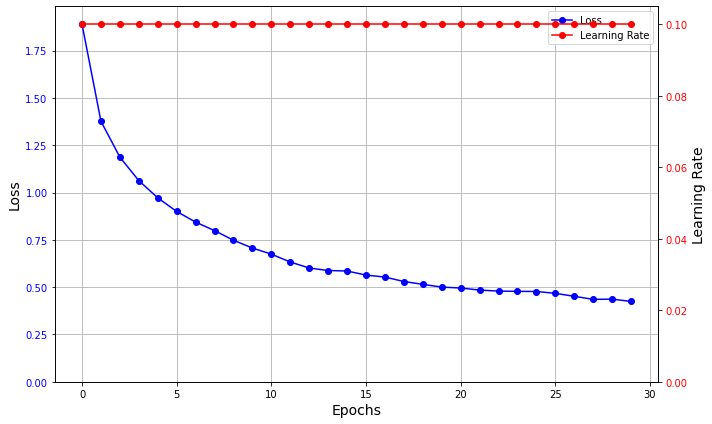

-----------------------------    model_cnnLSTM ----------------------------- 
Epoch: 1/20 - learning rate: 0.01000, classification loss: 1.5416
Epoch: 2/20 - learning rate: 0.01000, classification loss: 1.2054
Epoch: 3/20 - learning rate: 0.01000, classification loss: 1.0820
Epoch: 4/20 - learning rate: 0.01000, classification loss: 0.9877
Epoch: 5/20 - learning rate: 0.01000, classification loss: 0.9324
Epoch: 6/20 - learning rate: 0.01000, classification loss: 0.8626
Epoch: 7/20 - learning rate: 0.01000, classification loss: 0.7993
Epoch: 8/20 - learning rate: 0.01000, classification loss: 0.7720
Epoch: 9/20 - learning rate: 0.01000, classification loss: 0.7217
Epoch: 10/20 - learning rate: 0.01000, classification loss: 0.6898
Epoch: 11/20 - learning rate: 0.01000, classification loss: 0.6456
Epoch: 12/20 - learning rate: 0.01000, classification loss: 0.6171
Epoch: 13/20 - learning rate: 0.01000, classification loss: 0.5869
Epoch: 14/20 - learning rate: 0.01000, classification loss: 

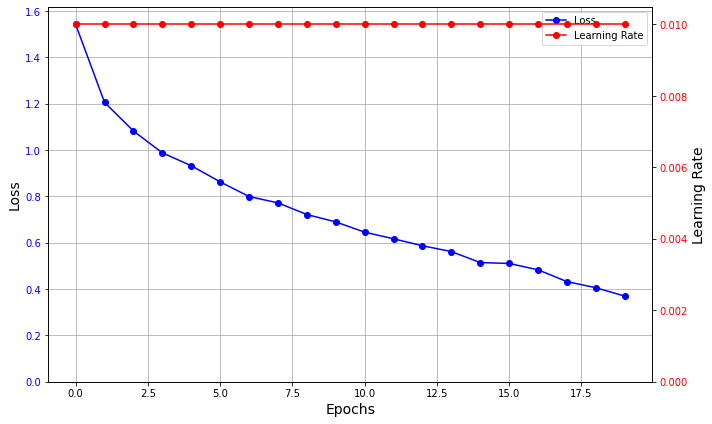

In [10]:
import copy
n_epochs = [30, 20]
n_epochs_da = 4

lr_threshold = 0.0005


for ii in range(len(models)):
    model = models[ii]
    #model.lstm.flatten_parameters()
    
    lr = lrs[ii]
    print('-----------------------------   ', models_names[ii],'----------------------------- ')
    #  training on source robot
    model, loss_seq, lr_seq = train_loop(model, train_dataloader, lr, n_epochs[ii])
    plot_loss(loss_seq, lr_seq)
     
    # Validation
    pre_training_accuracies = validation(test_dataloaders, dataloaders_names, model)
    print(pre_training_accuracies)

In [59]:
pre_training_accuracies

[83.85546803474426, 67.69230961799622, 28.184616565704346, 32.46753215789795]

### Domain Adaptation

-----------------------------    model_lstmBlock ----------------------------- 
                      # Training with target domain data  #
Epoch: 1/20 - learning rate: 0.10000, classification loss: 3.4355
Epoch: 2/20 - learning rate: 0.10000, classification loss: 1.1072
Epoch: 3/20 - learning rate: 0.10000, classification loss: 0.5114
Epoch: 4/20 - learning rate: 0.10000, classification loss: 0.2069
Epoch: 5/20 - learning rate: 0.10000, classification loss: 0.1121
Epoch: 6/20 - learning rate: 0.10000, classification loss: 0.0616
Epoch: 7/20 - learning rate: 0.10000, classification loss: 0.0471
Epoch: 8/20 - learning rate: 0.10000, classification loss: 0.0377
Epoch: 9/20 - learning rate: 0.10000, classification loss: 0.0309
Epoch: 10/20 - learning rate: 0.10000, classification loss: 0.0222
Epoch: 11/20 - learning rate: 0.10000, classification loss: 0.0170
Epoch: 12/20 - learning rate: 0.10000, classification loss: 0.0135
Epoch: 13/20 - learning rate: 0.10000, classification loss: 0.010

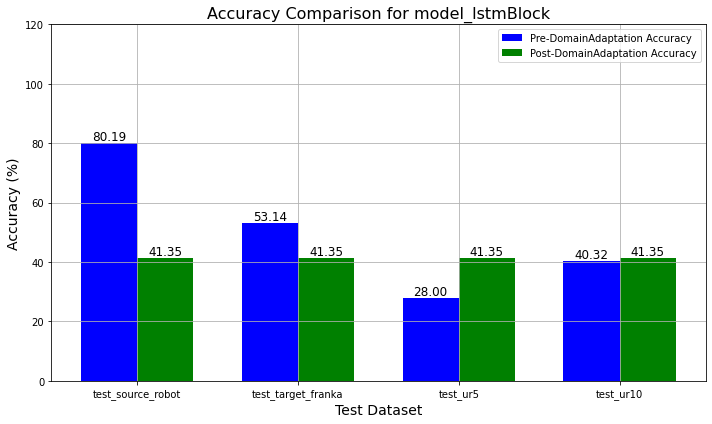

-----------------------------    model_cnnLSTM ----------------------------- 
                      # Training with target domain data  #
Epoch: 1/20 - learning rate: 0.01000, classification loss: 4.0286
Epoch: 2/20 - learning rate: 0.01000, classification loss: 1.4067
Epoch: 3/20 - learning rate: 0.01000, classification loss: 0.7024
Epoch: 4/20 - learning rate: 0.01000, classification loss: 0.4444
Epoch: 5/20 - learning rate: 0.01000, classification loss: 0.3747
Epoch: 6/20 - learning rate: 0.01000, classification loss: 0.2947
Epoch: 7/20 - learning rate: 0.01000, classification loss: 0.2279
Epoch: 8/20 - learning rate: 0.01000, classification loss: 0.1914
Epoch: 9/20 - learning rate: 0.01000, classification loss: 0.1291
Epoch: 10/20 - learning rate: 0.01000, classification loss: 0.0951
Epoch: 11/20 - learning rate: 0.01000, classification loss: 0.0715
Epoch: 12/20 - learning rate: 0.01000, classification loss: 0.0434
Epoch: 13/20 - learning rate: 0.01000, classification loss: 0.0453


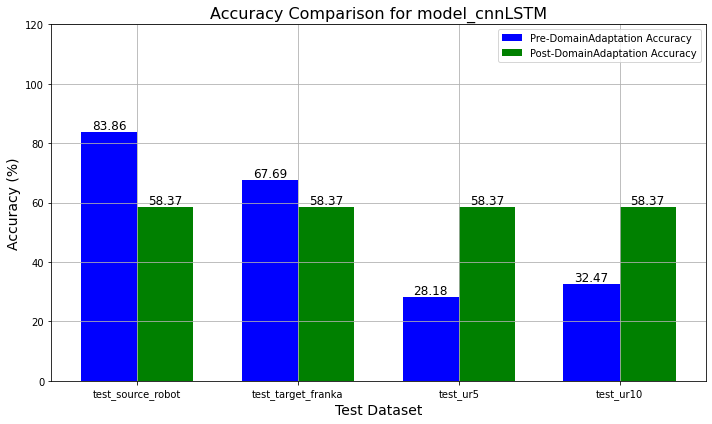

In [80]:
n_epochs_da = 20

lr_threshold = 0.0005
adopted_models = copy.deepcopy(models)

for ii in range(len(models)):
    model = adopted_models[ii]
    model.lstm.flatten_parameters()
    pre_training_accuracies = validation(test_dataloaders, dataloaders_names, model)
    
    lr = lrs[ii]
    print('-----------------------------   ', models_names[ii],'----------------------------- ')

    print('                      # Training with target domain data  #')
    
    # Train on target domain and validate again
    post_training_accuracies = []
    for i in [2]:#range(len(test_dataloaders)):
        dataset = test_dataloaders[i].dataset  # Extract the dataset from your existing DataLoader

        # Split the dataset: 10% for training, 90% for validation
        dataset_size = len(dataset)
        train_size = int(0.1 * dataset_size)
        val_size = dataset_size - train_size

        # Split the dataset
        target_train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

        # Create new DataLoaders for training and validation sets
        target_train_dataloader = DataLoader(target_train_dataset, batch_size=test_dataloaders[i].batch_size, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=test_dataloaders[i].batch_size, shuffle=False)

        # Train on target domain data
        model, loss_seq, lr_seq = train_loop(model, target_train_dataloader, lr, n_epochs_da, freeze_last_layer= False)

        # Validate on the same dataset and collect accuracies post-training
        post_training_accuracy = validation([val_dataloader], [dataloaders_names[i]], model)[0]
        post_training_accuracies.append(post_training_accuracy)
    
        # Reset model to pre-trained state if necessary
        
        model = copy.deepcopy(models[ii])
        model.lstm.flatten_parameters()
    
    # Plot accuracy comparison for the current model
    plot_accuracies(pre_training_accuracies, post_training_accuracies, dataloaders_names, models_names[ii])


## without domain adaptation

In [ ]:
# 10% ... without training on source domain
n_epochs_da = 4
model = models[2]
post_training_accuracies = []
for i in range(len(test_dataloaders)):
    model = models[2]
    dataset = test_dataloaders[i].dataset  # Extract the dataset from your existing DataLoader

    # Split the dataset: 10% for training, 90% for validation
    dataset_size = len(dataset)
    train_size = int(0.1 * dataset_size)
    val_size = dataset_size - train_size

    # Split the dataset
    target_train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create new DataLoaders for training and validation sets
    target_train_dataloader = DataLoader(target_train_dataset, batch_size=test_dataloaders[i].batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=test_dataloaders[i].batch_size, shuffle=False)

    # Train on target domain data
    model, loss_seq, lr_seq = train_loop(model, target_train_dataloader, lr, n_epochs_da)

    # Validate on the same dataset and collect accuracies post-training
    post_training_accuracy = validation([val_dataloader], [dataloaders_names[i]], model)[0]
    post_training_accuracies.append(post_training_accuracy)

    # Reset model to pre-trained state if necessary
    #model = model_pre_trained

# Plot accuracy comparison for the current model
plot_accuracies(pre_training_accuracies, post_training_accuracies, dataloaders_names, models_names[ii])

## save the best model

In [ ]:
# Save the trained model
named_tuple = time.localtime()
if input('Do you want to save the data in trained models? (y/n): ') == 'y':
    try:
        if collision:
            path_name_1 = path_name + '/collisionDetection/trainedModel' + str(time.strftime("_%m_%d_%Y_%H:%M:%S", named_tuple)) + '.pth'
            path_name_2 = path_name + '/collisionDetection/trainedModel.pth'
        elif localization:
            path_name_1 = path_name + '/localization/trainedModel' + str(time.strftime("_%m_%d_%Y_%H:%M:%S", named_tuple)) + '.pth'
            path_name_2 = path_name + '/localization/trainedModel.pth'
        elif num_classes == 2:
            path_name_1 = path_name + '/contactDetection/trainedModel' + str(time.strftime("_%m_%d_%Y_%H:%M:%S", named_tuple)) + '.pth'
            path_name_2 = path_name + '/contactDetection/trainedModel.pth'

        torch.save({"model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "collision": collision, "localization": localization, "network_type": network_type,
                    "n_epochs": n_epochs, "batch_size": batch_size, "num_features_lstm": num_features_lstm,
                    "num_classes": num_classes, "lr": lr}, path_name_1)
        
        torch.save({"model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "collision": collision, "localization": localization, "network_type": network_type,
                    "n_epochs": n_epochs, "batch_size": batch_size, "num_features_lstm": num_features_lstm,
                    "num_classes": num_classes, "lr": lr}, path_name_2)
        print('Model saved successfully!')
    except Exception as e:
        print(f"An error occurred while saving the model: {e}")

In [ ]:
# Load Model
model_path= 'with_0.1_0.1_1_scheduler/model_92_50epoches.pth'

num_classes = 7
num_features_dataset=7
num_features_lstm=1
batch_size= 4096

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Build the model

model = Sequence(num_features_lstm=num_features_lstm, num_layers=1, hidden_size=64, dropout=0.1)
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model = model.double().to(device)  # Move model to device

model.eval()

# Path to save trained models
model_path= 'model.pth'

# test on real-time data
## franka

In [75]:
import matplotlib.pyplot as plt
import plotly.graph_objs as go
def get_features_dof(features, joint_number):
    j = joint_number
    feature_j = []
    for i in range(len(features)) :
        feature_j.append(f'{features[i]}{j}' )
    return feature_j

# trained with training set
#contact_detection_path= main_path + 'model_cnnLSTMtest_source_robot.pth'

#model_contact = copy.deepcopy(models[0])
#checkpoint = torch.load(contact_detection_path)
#model_contact.load_state_dict(checkpoint["model_state_dict"])
#model_contact.to(device)

features = ['tau_J', 'tau_ext', 'e', 'de']
features = ['e']
dof = 7
#features_num = len(features)*dof
num_features_lstm = len(features)
window_length = 28
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
testing_data = pd.read_csv('/home/rzma/myProjects/contactInterpretation/frankaRobot/DATA/dataset/e4/labeled_data.csv')
testing_data['model_out'] = testing_data.label
testing_data['probability'] = testing_data.label
#testing_data = testing_data[(testing_data.index > 3000) & (testing_data.index < 5000)]; testing_data.reset_index(inplace=True)
#testing_data = testing_data[(testing_data.index < 4000)]; testing_data.reset_index(inplace=True)


for model_contact in adopted_models:
    #model_contact = copy.deepcopy(model)
    model_contact.eval()

    for t_i in range(window_length, testing_data.shape[0]):
        #building data window
        window = []
        for joint_number in range(dof):
            feature_j = get_features_dof(features=features, joint_number=joint_number)
            joint_row = np.hstack(testing_data[feature_j][t_i-window_length:t_i].values)
            window.append(joint_row)
            
        window = np.array([window])
        window = torch.tensor(window).to(device).double()
        with torch.no_grad():
            model_out = model_contact(window)
            #model_out = (model_out > 0.8).int() 
            probabilities = F.softmax(model_out) 
            testing_data.loc[t_i-1, 'probability'] = probabilities[probabilities.argmax().item()].item()
            '''testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item() #probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()
            
            '''
            if testing_data.loc[t_i-1, 'probability'] > 0.5:
                testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item()+1 #probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()
            else:
                testing_data.loc[t_i-1, 'model_out'] = 0

    # Create traces for the first dataset
    traces = []
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['model_out'], mode='lines', name='model_out'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['probability'], mode='lines', name='probability'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['label'], mode='lines', name='label'))

    # Create the layout
    layout = go.Layout(
        title='Combined Plot',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Values'),
        showlegend=True
    )

    # Create the figure and plot it
    fig = go.Figure(data=traces, layout=layout)
    fig.show()
    # calculate latency per contact event
    n = 80
    detection_delays = []
    true_label_index = testing_data.label[testing_data.label.diff()>0.9].index
    no_contact_start_index = testing_data.label[testing_data.label.diff()<-0.8].index
    no_contact_start_index = no_contact_start_index[no_contact_start_index>true_label_index[0]]

    predicted_label_index = testing_data.model_out[testing_data.model_out.diff()>0.9].index
    true_positive= np.zeros_like(true_label_index)
    counter = 0
    for i, end_i in zip(true_label_index, no_contact_start_index):
        state = False
        for j in range(end_i-i): 
            #if testing_data.model_out[i+j]:
            if (i+j) in predicted_label_index:
                detection_delays.append(testing_data.time[i+j]-testing_data.time[i])
                true_positive[counter]=1
                counter = counter +1
                state=True
                break
        if not state:
            true_positive[counter]=0
            counter = counter +1


    print('Single contact analysis')
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
    print(f'Effective Detection delay: {np.sum(detection_delays)/len(detection_delays):.3f} seconds')
    %matplotlib inline
    #plt.hist(detection_delays, bins=20)
    #plt.show()
    #plt.boxplot(detection_delays)

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 15,   contact labels: 15, percision: 1.0 
Effective Detection delay: 0.008 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:49: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 15,   contact labels: 15, percision: 1.0 
Effective Detection delay: 0.038 seconds


## ur5

In [82]:
save_data_file = main_path + 'urRobot/DATA/dataset/right_label_indexing/22/'
def get_features_dof(features, joint_number):
    j = joint_number
    feature_j = []
    for i in range(len(features)) :
        feature_j.append(f'{features[i]}{j}' )
    return feature_j


features = ['target_moment_', 'e_i', 'e', 'de']
features = ['e']
dof = 6
#features_num = len(features)*dof
num_features_lstm = len(features)

window_length = 28

k_tau = np.array([0.1082, 0.1100, 0.1097, 0.0787, 0.0294, 0.0261])*10 #ur robot support file
#k_tau = [1.35,  1.361, 1.355, 0.957, 0.865, 0.893] #my finding
#k_tau = np.array([0.1155, 0.1149 , 0.0988, 0.1032, 0.1033, 0.1030])*10 #ur10e
e_i = [f'e_i{i}' for i in range(dof)]

testing_data = pd.read_csv(save_data_file+'labeled_data.csv')
for i in range(len(e_i)):
    testing_data[e_i[i]]=testing_data[e_i[i]]*k_tau[i]

testing_data['model_out'] = testing_data.label
testing_data['probability'] = testing_data.label
#testing_data = testing_data[testing_data.index > 4000]; testing_data.reset_index(inplace=True)
# trained with training set
'''contact_detection_path= main_path + 'sequencetest_ur5.pth'

model_contact = copy.deepcopy(models[2])
checkpoint = torch.load(contact_detection_path)
model_contact.load_state_dict(checkpoint["model_state_dict"])
model_contact.to(device)
'''

for model_contact in adopted_models:
    model_contact.eval()

    for t_i in range(window_length, testing_data.shape[0]):
        #building data window
        window = []
        for joint_number in range(dof):
            feature_j = get_features_dof(features=features, joint_number=joint_number)
            joint_row = np.hstack(testing_data[feature_j][t_i-window_length:t_i].values)
            window.append(joint_row)
            
        #window = np.array(window)
        window = np.array([window])
        window_transformed = torch.tensor(window).to(device)
        with torch.no_grad():
            model_out = model_contact(window_transformed)
            #model_out = (model_out > 0.8).int() 
            probabilities = F.softmax(model_out) 
            testing_data.loc[t_i-1, 'probability'] = probabilities[probabilities.argmax().item()].item()
            
            if testing_data.loc[t_i-1, 'probability'] > 0.5:
                testing_data.loc[t_i-1, 'model_out'] = probabilities.argmax().item()+1 #probabilities[probabilities.argmax().item()].item()*probabilities.argmax().item()
            else:
                testing_data.loc[t_i-1, 'model_out'] = 0


    # Create traces for the first dataset
    traces = []
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['label'], mode='lines', name='label'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['model_out'], mode='lines', name='model_out'))
    traces.append(go.Scatter(x=testing_data['time'], y=testing_data['probability'], mode='lines', name='probability'))


    # Create the layout
    layout = go.Layout(
        title='Combined Plot',
        xaxis=dict(title='Time'),
        yaxis=dict(title='Values'),
        showlegend=True
    )

    # Create the figure and plot it
    fig = go.Figure(data=traces, layout=layout)
    fig.show()
    # calculate latency per contact event
    n = 80
    detection_delays = []
    true_label_index = testing_data.label[testing_data.label.diff()>0.9].index
    no_contact_start_index = testing_data.label[testing_data.label.diff()<-0.8].index
    no_contact_start_index = no_contact_start_index[no_contact_start_index>true_label_index[0]]

    predicted_label_index = testing_data.model_out[testing_data.model_out.diff()>0.9].index
    true_positive= np.zeros_like(true_label_index)
    counter = 0
    for i, end_i in zip(true_label_index, no_contact_start_index):
        state = False
        for j in range(end_i-i): 
            #if testing_data.model_out[i+j]:
            if (i+j) in predicted_label_index:
                detection_delays.append(testing_data.time[i+j]-testing_data.time[i])
                true_positive[counter]=1
                counter = counter +1
                state=True
                break
        if not state:
            true_positive[counter]=0
            counter = counter +1


    print('Single contact analysis')
    print(f'Correctly detected contacts(TP): {np.sum(true_positive)},   contact labels: {len(true_label_index)}, percision: {np.sum(true_positive)/len(true_label_index)} ')
    print(f'Effective Detection delay: {np.sum(detection_delays)/len(detection_delays):.3f} seconds')
    %matplotlib inline
    #plt.hist(detection_delays, bins=20)
    #plt.show()
    #plt.boxplot(detection_delays)
    

/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 8,   contact labels: 8, percision: 1.0 
Effective Detection delay: 0.005 seconds


/home/rzma/miniconda3/envs/franka/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning:

Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Single contact analysis
Correctly detected contacts(TP): 8,   contact labels: 8, percision: 1.0 
Effective Detection delay: 0.041 seconds


# k-fold cross validation

In [ ]:
import torch.optim as optim
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

# Parameters
k_folds = 5
num_epochs = 10
batch_size = 16
learning_rate = 0.001

# K-Fold Cross-Validation
kfold = KFold(n_splits=k_folds, shuffle=True)

# Store results
results = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(training_data)):
    print(f'Fold {fold + 1}/{k_folds}')
    
    # Create data loaders
    train_subset = Subset(training_data, train_idx)
    val_subset = Subset(training_data, val_idx)
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    # Initialize the model, optimizer, and loss function
    model = lstmBlock(num_features_lstm=num_features_lstm, num_layers=1, hidden_size=64, dropout=0.5, bidirectional=True)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(inputs.float())  # Forward pass
            loss = criterion(outputs, labels.long())  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update parameters

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Validation loop
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs.float())  # Forward pass
            _, predicted = torch.max(outputs, 1)  # Get the predicted class
            total_correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = total_correct / len(val_subset)
    results.append(accuracy)
    print(f'Fold {fold + 1} Accuracy: {accuracy:.4f}')

# Average accuracy across all folds
print(f'Average Accuracy: {np.mean(results):.4f}')